In [180]:
import os
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
csv_file1 = '/home/taveesh/Documents/Projects/vca-qoe-inference/data/conext_data/logs_Teams_06-15_rush_hour/capture/1032_151_15575_5616_42_1655395784.csv'
# csv_file_teams = '/home/taveesh/Documents/Projects/vca-qoe-inference/data/Data_bernoulli/vca_data/teams/upton_data/2023-02-09_teams_1000_0_0_500_10_0_57_8/teams/captures/teams-chrome-1000-0-0-500-10-0-57-8-1675978145.csv'
csv_files_meet = '/home/taveesh/Documents/PhD-Research/Code/vca-qoe-inference/data/Data_bernoulli/vca_data/meet/upton_data'
csv_files_webex = '/home/taveesh/Documents/PhD-Research/Code/vca-qoe-inference/data/Data_bernoulli/vca_data/webex/upton_data'
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib
import sys
import pandas as pd
from os.path import dirname, abspath
from sklearn.metrics import mean_absolute_error
import random
from collections import defaultdict

In [8]:
def filter_ptype(x):
    if type(x) != str and math.isnan(x):
        return x
    x = str(x)
    if ',' in x:
        return str(int(float(x.split(',')[0])))
    return str(int(float(x)))


def mark_video_frames(pcap):
    pcap["is_video_pred"] = (
        pcap["udp.length"] > project_config['video_thresh']).astype(np.int32)
    return pcap


def filter_video_frames(pcap):
    pcap = pcap[pcap["udp.length"] > project_config['video_thresh']]
    return pcap

def filter_video_frames_rtp(pcap, vca):
    if vca == 'webex':
        top_num = 1
    else: 
        top_num = 2
    pcap['rtp.p_type'] = pcap['rtp.p_type'].apply(filter_ptype)
    top_x = pcap.groupby(['rtp.p_type'])['udp.length'].mean().nlargest(top_num).index.tolist()
    condition = ((pcap['rtp.p_type'].isin(top_x)))
    return pcap[condition]

def read_net_file(filename, ip, vca):
    csv_columns = ['frame.time_relative', 'frame.time_epoch', 'ip.src', 'ip.dst', 'ip.proto', 'ip.len',
                   'udp.srcport', 'udp.dstport', 'udp.length', 'rtp.ssrc', 'rtp.timestamp', 'rtp.seq', 'rtp.p_type', 'rtp.marker']
    df_net = pd.read_csv(filename, header=None, sep='\t',
                         names=csv_columns, lineterminator='\n', encoding='ascii')
    df_net = df_net[(df_net["ip.dst"] == ip) & (
        ~pd.isna(df_net["rtp.ssrc"]))]
    
    df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(filter_ptype)
    df_net['rtp.p_type'] = df_net['rtp.p_type'].dropna()
    if df_net['ip.proto'].dtype == object:
        df_net = df_net[df_net['ip.proto'].str.contains(',') == False]
    df_net = df_net[~df_net['ip.proto'].isna()]
    df_net['ip.proto'] = df_net['ip.proto'].astype(int)
    df_net = filter_video_frames_rtp(df_net, vca)
    if df_net.empty:
        return
    return df_net

def get_net_stats(df_video, ft_end_col="frame_et"):
    
    ## frame duration calculations
    df_video["frame_st"] = df_video["frame_st"].apply(lambda x: float(x))
    df_video["frame_et"] = df_video["frame_et"].apply(lambda x: float(x))
    df_video["frame_size"] = df_video["frame_size"].apply(lambda x: float(x))
    df_video["frame_dur"] = df_video[ft_end_col].diff()
    df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
    df_video = df_video.fillna(0)
    
    ## freeze calculation
    df_video["is_freeze"] = df_video.apply(is_freeze, axis=1)
    df_video["freeze_dur"] = df_video.apply(get_freeze_dur, axis=1)
    
    ## obtain per second stats
    df_video["frame_et_int"] = df_video[ft_end_col].apply(lambda x: int(x)+1)
    df_grp = df_video.groupby("frame_et_int").agg({"frame_size" : ["sum", "count"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur': 'freeze_dur',
                                    'lost_frame': 'frames_lost',
                                    'frame_dur': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000    
    return df_grp

In [36]:
idx = 0
for exp in os.listdir(csv_files_meet):
    fname = [x for x in os.listdir(f'{csv_files_meet}/{exp}/meet/captures') if x.endswith('.csv')][0]
    # print(f'{exp}/meet/captures/{fname}')
    df = read_net_file(f'{csv_files_meet}/{exp}/meet/captures/{fname}', '192.168.1.187', 'meet')
    if df is None or len(df) == 0:
        continue
    df = df.sort_values(by='frame.time_relative')
    idx += 1
    if idx == 7:
        break
print(f'{exp}/meet/captures/{fname}')
    # dfg['range'] = dfg['lmax']-dfg['lmin']
    # data.append(dfg)
# dff = pd.concat(data, axis=0)
# plt.figure()
# sns.ecdfplot(data=dff, x = 'range')
# plt.figure()
# sns.ecdfplot(data=dff, x = 'lstd')

2023-02-08_meet_2000_0_5000_5000_0_0_46_476/meet/captures/meet-chrome-2000-0-5000-5000-0-0-46-476-1675941935.csv


In [37]:
df_sub = df[['frame.time_relative', 'udp.length', 'rtp.seq', 'rtp.timestamp', 'rtp.p_type']]

In [38]:
df_sub.head(10)
df_sub.to_csv('/home/taveesh/Desktop/trace.csv')

In [39]:
rtp_ts = df['rtp.timestamp'].unique()
prev = 0
for ts in rtp_ts:
    print('=========================Video==============================')
    print('Packet Length:', list(df[(df['rtp.timestamp'] == ts) & (df['rtp.p_type'] == '98')]['udp.length']))
    print('Relative time', list(df[(df['rtp.timestamp'] == ts) & (df['rtp.p_type'] == '98')]['frame.time_relative']))
    print('Sequence numbers', list(df[(df['rtp.timestamp'] == ts) & (df['rtp.p_type'] == '98')]['rtp.seq']))
    print('--------------------------RTX-------------------------------')
    print('Packet Length:', list(df[(df['rtp.timestamp'] == ts) & (df['rtp.p_type'] == '99')]['udp.length']))
    print('Relative time', list(df[(df['rtp.timestamp'] == ts) & (df['rtp.p_type'] == '99')]['frame.time_relative']))
    print('Sequence numbers', list(df[(df['rtp.timestamp'] == ts) & (df['rtp.p_type'] == '99')]['rtp.seq']))

=========================Video==============================
Packet Length: [1005.0, 1017.0, 1018.0, 1018.0, 1014.0]
Relative time [0.64119623, 0.666769814, 0.670916908, 0.692431491, 0.696622906]
Sequence numbers [0.0, 1.0, 2.0, 3.0, 4.0]
--------------------------RTX-------------------------------
Packet Length: [1007.0]
Relative time [0.645615019]
Sequence numbers [8142.0]
=========================Video==============================
Packet Length: [1202.0, 1214.0, 1215.0, 1215.0, 1215.0]
Relative time [0.716691115, 0.721531183, 0.743901937, 0.772119304, 0.777186146]
Sequence numbers [5.0, 6.0, 7.0, 8.0, 9.0]
--------------------------RTX-------------------------------
Packet Length: [1217.0, 1217.0, 1217.0]
Relative time [0.748954219, 0.800900449, 0.8058283]
Sequence numbers [8144.0, 8145.0, 8146.0]
=========================Video==============================
Packet Length: [1130.0]
Relative time [0.962765197]
Sequence numbers [10.0]
--------------------------RTX---------------------

In [33]:
pcap = '/home/taveesh/Documents/PhD-Research/Code/vca-qoe-inference/data/Data_bernoulli/vca_data/meet/upton_data/2023-02-08_meet_2000_0_1500_0_20_0_42_365/meet/captures/meet-chrome-2000-0-1500-0-20-0-42-365-1675931938.pcap'
from scapy.all import *

scapy_cap = rdpcap(pcap)
for pkt in scapy_cap:
    if pkt.haslayer(IP):
        ip_pkt = pkt[IP]
        if pkt.haslayer(UDP):
            udp_pkt = pkt[UDP]
        if ip_pkt.dst == '192.168.1.187':
            if udp_pkt.sport == 3478:
                rtp_packet = RTP(bytes(udp_pkt.payload))
                if rtp_packet.version == 2 and not (rtp_packet.payload_type >= 64 and rtp_packet.payload_type <= 95):
                    time_relative = pkt.time - scapy_cap[0].time
                    sequence = rtp_packet.sequence
                    if sequence == 14597:
                        rtp_packet.show()
                        payload = bytes(rtp_packet.payload.load)
print(payload[0]*256 + payload[1])
# print(ord(payload[0].decode('UTF-8','replace'))*256 + ord(payload[1].decode('UTF-8','replace')))

###[ RTP ]### 
  version   = 2
  padding   = 0
  extension = 1
  numsync   = 0
  marker    = 1
  payload_type= 99
  sequence  = 14597
  timestamp = 4076976461
  sourcesync= 1782361359
  sync      = []
###[ RTP extension ]### 
     header_id = 4096
     header_len= 9
     header    = [33787217, 738394624, 1493634305, 9, 655370, 20, 252134144, 35258376, 0]
###[ Raw ]### 
        load      = '\\xc1*\x0c?\\xb5{\\xa4\\x98k\\xb8\x11\\x9cRKeӂ\\x8d\'\\x87\\xf3\\xd3O\\xb0/%g䏄\x08a\u05faJ1\\xcfoC\x02\\xaax\\xe1]\\xfe\\xca\\xe6\\xb2=g\\xa4\x16q\x1e\\xc4z\\x97\x00\x1fD\\x9c\\xa2\\xb0*\\xd8\n``\\xd2\\xf0X\\xcb|5\\xcek\\xa4\\xe0\\xfe\\x8b\r\\xa2\\xffr\\x80\\xfcFl\\x8b\\xb1-K\\xc0O\\xf7\\xc5\\xc3\x08\\xfcP\\xa26B#\\xe7\\xf5W\\xb1H\\xbf2y\\xb4\\x90\\xd3\x0c1\\xb9\\x91\\xbc\tlօ\\xe2\\x941\'\\x99\x1a,\\x88#՛\\xe5\\xa5\\xca\\xc3\\xf0\\xb0\\xab_\\xbec\\xc4\x1eM\x1f\\x97\x0bǂ\\xdc/\\x9ch\x1b\\xc6\\xd2i`\\xf6)\\xe1\\xb5\\xe8\\xdf\\xf5\\xe1U\\xceu\\xac;{\\xc0F\\x96\\xfb؈p\x7f%\\x92\\xf6:\\x91\\xb8\\xfar/\\xb

In [115]:
cv_splitfile = '/home/taveesh/Documents/PhD-Research/Code/vca-qoe-inference/data/Data_bernoulli_cv_splits/cv_file_splits.pkl'
import pickle
with open(cv_splitfile, 'rb') as fd:
    cv_split = pickle.load(fd)
meet_files = cv_split[0]['meet']['train'] + cv_split[0]['meet']['test']

In [116]:
import pandas as pd
import json, re, ast, numpy as np
import dateutil.parser
from datetime import datetime
import sys
from os.path import dirname, abspath

project_config = {'webrtc_format': 2}

class WebRTCReader:
    def __init__(self, webrtc_file):
        self.webrtc_file = webrtc_file

        if project_config['webrtc_format'] == 1:
            self.wanted_stats = {"RTCInboundRTPVideoStream" : ["ssrc", "lastPacketReceivedTimestamp", \
                    "framesPerSecond", "[bytesReceived_in_bits/s]", "[codec]", "packetsLost",\
                    "framesDropped", "framesReceived", "[framesReceived/s]", "[interFrameDelayStDev_in_ms]", "nackCount", "packetsReceived", "jitterBufferDelay", "[framesDecoded/s]", "jitterBufferEmittedCount"], \
                    "RTCMediaStreamTrack_receiver" : ["trackIdentifier", "freezeCount*","totalFreezesDuration*", \
                    "totalFramesDuration*", "pauseCount*", "totalPausesDuration*"]}
        else:
            self.wanted_stats = {"IT01V" : ["ssrc", "lastPacketReceivedTimestamp", \
            "framesPerSecond", "[bytesReceived_in_bits/s]", "[codec]", "packetsLost",\
            "framesDropped", "framesReceived", "[framesReceived/s]", "[interFrameDelayStDev_in_ms]", "nackCount", "packetsReceived", "trackIdentifier", "freezeCount","totalFreezesDuration", "pauseCount", "totalPausesDuration", "jitterBufferDelay", "[framesDecoded/s]", "jitterBufferEmittedCount"]}

        self.cum_stat_list = ["freezeCount*", "totalFreezesDuration*", "totalFramesDuration*", "framesReceived", "pauseCount*", "totalPausesDuration*", "jitterBufferDelay", "jitterBufferEmittedCount"]


    def get_most_active(self, webrtc_stats, id_list):
        stat_temp = "RTCInboundRTPVideoStream_%s-framesPerSecond" if project_config['webrtc_format'] == 1 else "IT01V%s-framesPerSecond"
        valid_id_list = [id_list[i] for i in range(len(id_list)) if stat_temp % id_list[i] in webrtc_stats]
        sum_list = [sum(ast.literal_eval(webrtc_stats[stat_temp % ssrc_id]["values"])) for ssrc_id in valid_id_list]
        if len(sum_list) == 0:
            return None
        index_max = np.argmax(sum_list)
        return valid_id_list[index_max]
        
    def is_cum_stat(self, x):
        for cum_stat in self.cum_stat_list:
            if '-'+cum_stat in x:
                return True
        return False

    def get_active_stream(self, webrtc_stats, pref):
        id_map = {}
        for k in webrtc_stats:
            m = re.search(f"{pref}_(\d+)-", k) if project_config['webrtc_format'] == 1 else re.search(f"{pref}(\d+)-", k)
            if not m:
                continue
            id1 = m.group(1)
            id_map[id1] = 1
        return list(id_map.keys())

    def get_stat(self, stat_name, st_time, et_time, val_list):
        st_dt = datetime.timestamp(dateutil.parser.parse(st_time))
        et_dt = datetime.timestamp(dateutil.parser.parse(et_time))
        (t, i) = (int(st_dt), 0)
        l = []
        while t < et_dt and i < len(val_list):
            l.append([t, val_list[i]])
            i += 1
            t += 1
        stat_suff = stat_name.split("-")[1]
        df = pd.DataFrame(l, columns=["ts", stat_suff])
        return df 

    def get_webrtc(self):
        webrtc = json.load(open(self.webrtc_file))
        active_ids = []
        try:
            unknown_key = None
            for k in webrtc["PeerConnections"].keys():
                if len(webrtc["PeerConnections"][k]["stats"]) == 0:
                    continue
                webrtc_stats = webrtc["PeerConnections"][k]["stats"]
                pref = "RTCInboundRTPVideoStream" if project_config['webrtc_format'] == 1 else "IT01V"
                active_ids = self.get_active_stream(webrtc_stats, pref) # Gets a list of SSRC IDs
                id1 = self.get_most_active(webrtc_stats, active_ids)
                if len(id1) > 0:
                    break
        except:
            return pd.DataFrame()
        if len(active_ids) == 0:
            print("no inbound stream")
            return pd.DataFrame()

        if id1 is None:
            print('No frames seen in this trace')
            return pd.DataFrame()

        ##

        stat_names = [f"{pref}_{id1}-{stat}" for stat in self.wanted_stats[pref]] if project_config['webrtc_format'] == 1 else [f"{pref}{id1}-{stat}" for stat in self.wanted_stats[pref]]

        media_field = f"{pref}_{id1}-trackId" if project_config['webrtc_format'] == 1 else f"{pref}{id1}-trackId"

        media_track = list(set(ast.literal_eval(webrtc_stats[media_field]["values"])))
        
        if len(media_track) == 0:
            print(f"No media track in file {self.webrtc_file}")
            return pd.DataFrame()
        elif len(media_track) > 1:
            print(f"More than 1 media track in {self.webrtc_file}")
        
        df_all = pd.DataFrame()
        if project_config['webrtc_format'] == 1:
            pref = "RTCMediaStreamTrack_receiver"
            stat_names += [f"{media_track[0]}-{stat}" for stat in self.wanted_stats[pref]]
        try:
            for stat in stat_names:

                if stat.startswith('DEPRECATED'):
                    continue

                (st_time, et_time) = (webrtc_stats[stat]["startTime"], webrtc_stats[stat]["endTime"])
                val_str = webrtc_stats[stat]["values"]
                val_list = ast.literal_eval(val_str)
                if self.is_cum_stat(stat):
                    val_list = [val_list[0]] + [val_list[i] - val_list[i-1] for i in range(1, len(val_list))] # [start_val, diff_between_consecutive_vals]

                df_stat = self.get_stat(stat, st_time, et_time, val_list)
                # print(stat)
                # print(df_stat.isna())
                if df_all.empty:
                    df_all = df_stat
                else:
                    df_all = pd.merge(df_all, df_stat, on="ts", how="outer")
        except:
            print(f'Something went wrong for stat {stat} in file {self.webrtc_file}')
            return pd.DataFrame()
        df_all = df_all.rename(columns={'[framesReceived/s]': 'framesReceivedPerSecond', '[framesDecoded/s]': 'framesDecodedPerSecond'})
        return df_all


In [259]:
class RTPModel:
    def __init__(self, vca, metric):
        self.metric = metric
        self.vca=vca
        self.video_ptype = {'meet': '98', 'teams': '102', 'webex': '102'}
        
    def filter_ptype(self, x):
        if type(x) != str and math.isnan(x):
            return x
        x = str(x)
        if ',' in x:
            return str(int(float(x.split(',')[0])))
        return str(int(float(x)))


    def mark_video_frames(self, pcap):
        pcap["is_video_pred"] = (
            pcap["udp.length"] > 306).astype(np.int32)
        return pcap


    def filter_video_frames(self, pcap):
        pcap = pcap[pcap["udp.length"] > 306]
        return pcap

    def filter_video_frames_rtp(self, pcap, vca):
        if vca == 'webex':
            top_num = 1
        else: 
            top_num = 2
        pcap['rtp.p_type'] = pcap['rtp.p_type'].apply(self.filter_ptype)
        top_x = pcap.groupby(['rtp.p_type'])['udp.length'].mean().nlargest(top_num).index.tolist()
        condition = ((pcap['rtp.p_type'].isin(top_x)))
        return pcap[condition]

    def read_net_file(self, filename, ip, vca):
        csv_columns = ['frame.time_relative', 'frame.time_epoch', 'ip.src', 'ip.dst', 'ip.proto', 'ip.len',
                       'udp.srcport', 'udp.dstport', 'udp.length', 'rtp.ssrc', 'rtp.timestamp', 'rtp.seq', 'rtp.p_type', 'rtp.marker']
        df_net = pd.read_csv(filename, header=None, sep='\t',
                             names=csv_columns, lineterminator='\n', encoding='ascii')
        df_net = df_net[(df_net["ip.dst"] == ip) & (
            ~pd.isna(df_net["rtp.ssrc"]))]

        df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(self.filter_ptype)
        df_net['rtp.p_type'] = df_net['rtp.p_type'].dropna()
        if df_net['ip.proto'].dtype == object:
            df_net = df_net[df_net['ip.proto'].str.contains(',') == False]
        df_net = df_net[~df_net['ip.proto'].isna()]
        df_net['ip.proto'] = df_net['ip.proto'].astype(int)
        if df_net.empty:
            return
        return df_net
    
    def is_freeze(self, x):
        if x["frame_dur"] > max(3*x["avg_frame_dur"], (x["avg_frame_dur"] + 0.150)):
            return 1
        else:
            return 0

    def get_freeze_dur(self, x):
        if x["is_freeze"] == 1:
            return x["frame_dur"]
        else:
            return 0

    def get_net_stats(self, df_video, ft_end_col="frame_et"):

        ## frame duration calculations
        df_video["frame_st"] = df_video["frame_st"].apply(lambda x: float(x))
        df_video["frame_et"] = df_video["frame_et"].apply(lambda x: float(x))
        df_video["frame_size"] = df_video["frame_size"].apply(lambda x: float(x))
        df_video["frame_dur"] = df_video[ft_end_col].diff()
        df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
        df_video = df_video.fillna(0)

        ## freeze calculation
        df_video["is_freeze"] = df_video.apply(self.is_freeze, axis=1)
        df_video["freeze_dur"] = df_video.apply(self.get_freeze_dur, axis=1)

        ## obtain per second stats
        df_video["frame_et_int"] = df_video[ft_end_col].apply(lambda x: int(x)+1)
        df_grp = df_video.groupby("frame_et_int").agg({"frame_size" : ["sum", "count"], "is_freeze": "sum", 
                                                 "freeze_dur": "sum", "frame_dur": "std"}).reset_index()

        ## rename columns
        df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
        df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                        'is_freeze': 'freeze_count',
                                        'frame_size_sum': 'bitrate',
                                        'freeze_dur': 'freeze_dur',
                                        'lost_frame': 'frames_lost',
                                        'frame_dur': 'interframe_delay_std'
                                       })
        df_grp['bitrate'] = df_grp['bitrate']*8/1000    
        return df_grp
    
    def get_frame_arrival_time(self, x):
        return x['iat'][0] if len(x['iat']) == 1 else max(x['frame.time_epoch']) - min(x['frame.time_epoch'])
    
    def ip_udp_estimate(self, file_tuple):
        pcap_file = file_tuple[0]
        csv_file = file_tuple[1]
        webrtc_file = file_tuple[2]
        df = self.read_net_file(csv_file, '192.168.1.187', self.vca)
        if df is None:
            return None
        df = df.fillna(0)
        df['frame.time_relative'] = df['frame.time_relative'].astype(float)
        df = df.sort_values(by=['frame.time_relative'])
        df['iat'] = df['frame.time_epoch'].diff()
    
    def custom_size_var1(self, x):
        if len(x) == 1:
            return 0
        a = np.array(x[1:])
        return a.max()-a.min()
    
    def custom_size_diff1(self, x):
        if len(x) == 1:
            return 0
        a = np.array(x)
        return a.max()-a[0]
        
    def estimate(self, file_tuple):
        pcap_file = file_tuple[0]
        csv_file = file_tuple[1]
        webrtc_file = file_tuple[2]
        df = self.read_net_file(csv_file, '192.168.1.187', self.vca)
        df = self.filter_video_frames_rtp(df, self.vca)
        if df is None:
            return None
        df['frame.time_relative'] = df['frame.time_relative'].astype(float)
        df = df.sort_values(by=['frame.time_relative'])
        dfg = df.groupby(["rtp.timestamp", "rtp.p_type"]).agg({'frame.time_epoch': len, 'udp.length': list}).reset_index()
        num_pkts = defaultdict(lambda: 0)
        num_rtx = defaultdict(lambda: 0)
        for idx, ts in dfg.iterrows():
            num_pkts[ts['rtp.timestamp']] += ts['frame.time_epoch']
            if ts['rtp.p_type'] == '99':
                num_rtx[ts['rtp.timestamp']] += ts['frame.time_epoch']
                
        df['iat'] = df['frame.time_epoch'].diff()
        df = df.fillna(0)
        df = df[df['rtp.p_type'] == self.video_ptype[self.vca]]
        df['rtp.seq'] = df['rtp.seq'].apply(int)
        df_grp = df.groupby("rtp.timestamp").agg({"frame.time_epoch": list, "udp.length": list, "rtp.seq": list, 'iat': list}).reset_index()
        df_grp['num_pkts'] = df_grp['rtp.timestamp'].apply(lambda x: num_pkts[x])
        df_grp['num_rtx'] = df_grp['rtp.timestamp'].apply(lambda x: num_rtx[x])
        df_grp['size_diff'] = df_grp['udp.length'].apply(self.custom_size_var1)
        df_grp['diff_1'] = df_grp['udp.length'].apply(self.custom_size_diff1)
        df_grp['frame_arr_time'] = df_grp[['iat', 'frame.time_epoch']].apply(self.get_frame_arrival_time, axis=1)
        to_discard = set()
        for i in range(df_grp.shape[0]):
            seq_no_list = sorted(df_grp.iloc[i]['rtp.seq'])
            if i == 0:
                min_seq_no = seq_no_list[0]-1
            for j in range(len(seq_no_list)):
                if seq_no_list[j] != min_seq_no + 1:
                    if j == 0:
                        if i == 0 or df_grp['frame_arr_time'].iloc[i] > df_grp['frame_arr_time'].iloc[i-1]:
                            to_discard.add(i)
                        else:
                            to_discard.add(i-1)
                    else:
                        to_discard.add(i)
                    break
                min_seq_no = seq_no_list[j]
            min_seq_no = seq_no_list[-1]
        df_grp['discarded'] = 'No'
        for x in to_discard:
            df_grp.at[x, 'discarded'] = 'Yes'
        df_grp = df_grp.drop(to_discard, axis=0)
        # df_grp["frame_st"] = df_grp["frame.time_epoch"].apply(lambda x: min(x))
        # df_grp["frame_et"] = df_grp["frame.time_epoch"].apply(lambda x: max(x))
        # df_grp["frame_size"] = df_grp["udp.length"].apply(lambda x: sum(x))
        # df_grp = self.get_net_stats(df_video=df_grp)
        # webrtc_reader = WebRTCReader(webrtc_file)
        # df_webrtc = webrtc_reader.get_webrtc()[[self.metric, 'ts']]
        # col = "frame_et_int"
        # df_test = pd.merge(df_grp, df_webrtc, left_on=col, right_on="ts")
        # df_test = df_test.dropna()
        # mae = round(mean_absolute_error(df_test['fps'], df_test['framesReceived']), 2)
        # print(f'MAE = {mae}')
        # if mae > 10:
        #     print(webrtc_file)
        #     print(df_test[['fps', 'framesReceived']])
        # metric_col = f'{self.metric}_rtp'
        # # webrtc_col = f'{self.metric}_webrtc'
        # if self.metric == 'framesPerSecond' or self.metric == 'framesReceivedPerSecond' or self.metric == 'framesReceived':
        #     # df_merge = df_merge.rename(columns={'fps': metric_col, self.metric: webrtc_col, 'ts': 'timestamp'})
        #     df_grp = df_grp.rename(columns={'fps': metric_col, col: 'timestamp'})
        # df_grp['file'] = pcap_file
        # # df_merge = df_merge[[webrtc_col, metric_col, 'timestamp']]
        # # df_merge = df_merge.dropna()
        # # df_merge['file'] = pcap_file
        return df_grp

In [260]:
rtp_model = RTPModel('meet','framesReceived')
data = []
for file_tuple in meet_files:
    data.append(rtp_model.estimate(file_tuple))
df = pd.concat(data, axis=0) 

In [261]:
df['frame_arr_time'].quantile([0.25, 0.5, 0.75, 0.9, 0.91, 0.92, 0.93, 0.94, 0.85, 0.96, 0.97, 0.98, 0.99, 0.999, 1])

0.250    0.006797
0.500    0.018122
0.750    0.033077
0.900    0.043039
0.910    0.043775
0.920    0.044525
0.930    0.045178
0.940    0.045711
0.850    0.039303
0.960    0.046870
0.970    0.047426
0.980    0.048110
0.990    0.049801
0.999    0.076541
1.000    8.719739
Name: frame_arr_time, dtype: float64

In [239]:
df['frame_arr_time'] *= 1000
df.head(5)

,rtp.timestamp,frame.time_epoch,udp.length,rtp.seq,iat,num_pkts,num_rtx,size_diff,diff_1,frame_arr_time,discarded
0,3.104178e+09,"[1675903888.138744, 1675903888.1645603, 167590...","[971.0, 983.0, 983.0]","[0, 1, 2]","[0.0, 0.017934799194335938, 0.008377552032470703]",9,6,0.0,12.0,34.193754,No
1,3.104181e+09,"[1675903888.1891224, 1675903888.2136707, 16759...","[1149.0, 1161.0, 1161.0, 1161.0, 1162.0, 1162.0]","[4, 5, 6, 7, 8, 9]","[0.016184568405151367, 0.02454829216003418, 0....",8,2,1.0,13.0,104.182005,Yes
2,3.104196e+09,"[1675903888.31801, 1675903888.3259895]","[956.0, 964.0]","[10, 11]","[0.015161991119384766, 0.007979393005371094]",11,9,0.0,8.0,7.979393,No
3,3.104207e+09,[1675903888.4598489],[1210.0],[12],[0.010117292404174805],2,1,0.0,0.0,10.117292,No
4,3.104210e+09,[1675903888.4707713],[1178.0],[14],[0.010922431945800781],10,9,0.0,0.0,10.922432,Yes


In [240]:
df['num_vid'] = df['num_pkts']-df['num_rtx']

In [241]:
df.shape

(835989, 12)

In [236]:
df['size_diff'].quantile(list(map(lambda x: x/1000, list(range(990, 1000, 1)))))

0.990    1.0
0.991    1.0
0.992    1.0
0.993    1.0
0.994    1.0
0.995    1.0
0.996    1.0
0.997    1.0
0.998    1.0
0.999    4.0
Name: size_diff, dtype: float64

In [243]:
df['diff_1'].quantile(list(map(lambda x: x/1000, list(range(1, 1000, 10)))))

0.001     0.0
0.011     0.0
0.021     0.0
0.031     0.0
0.041     0.0
         ... 
0.951     1.0
0.961     1.0
0.971     1.0
0.981    13.0
0.991    17.0
Name: diff_1, Length: 100, dtype: float64

In [250]:
df[df['discarded'] == 'Yes']['num_rtx'].quantile(list(map(lambda x: x/1000, list(range(960, 1000, 1)))))

0.960     2.0
0.961     2.0
0.962     2.0
0.963     2.0
0.964     2.0
0.965     2.0
0.966     2.0
0.967     2.0
0.968     2.0
0.969     2.0
0.970     2.0
0.971     2.0
0.972     2.0
0.973     2.0
0.974     2.0
0.975     2.0
0.976     3.0
0.977     3.0
0.978     3.0
0.979     3.0
0.980     3.0
0.981     3.0
0.982     3.0
0.983     3.0
0.984     3.0
0.985     3.0
0.986     4.0
0.987     4.0
0.988     4.0
0.989     5.0
0.990     5.0
0.991     6.0
0.992     7.0
0.993     7.0
0.994     9.0
0.995     9.0
0.996    11.0
0.997    12.0
0.998    15.0
0.999    19.0
Name: num_rtx, dtype: float64

In [247]:
df['frame_arr_time'].quantile(list(map(lambda x: x/100, list(range(35, 100, 1)))))

0.35    11.026144
0.36    11.518478
0.37    12.134790
0.38    12.912350
0.39    13.855457
          ...    
0.95    48.230791
0.96    49.899578
0.97    54.854822
0.98    65.540962
0.99    78.876257
Name: frame_arr_time, Length: 65, dtype: float64

In [251]:
df[df['discarded'] == 'Yes']['frame_arr_time'].quantile(list(map(lambda x: x/100, list(range(0, 101, 2))))+[0.999])

0.000       0.488520
0.020       5.229473
0.040       5.911083
0.060       6.975908
0.080       9.982758
0.100      10.432196
0.120      11.248150
0.140      14.278069
0.160      15.510054
0.180      15.943584
0.200      17.580414
0.220      19.117575
0.240      20.226555
0.260      20.808697
0.280      21.403818
0.300      22.446156
0.320      23.644514
0.340      24.733686
0.360      25.746698
0.380      26.746750
0.400      28.066635
0.420      29.295101
0.440      30.349951
0.460      31.264811
0.480      32.166872
0.500      33.166885
0.520      34.138308
0.540      35.082312
0.560      36.016998
0.580      37.120552
0.600      38.360071
0.620      39.702215
0.640      40.864592
0.660      42.057514
0.680      43.411732
0.700      44.741535
0.720      45.835247
0.740      47.096329
0.760      48.535509
0.780      50.783234
0.800      53.664637
0.820      57.002802
0.840      60.397501
0.860      64.617748
0.880      67.465830
0.900      72.270441
0.920      77.805519
0.940      79

In [159]:
df['pps'] = df['num_pkts']/df['frame_arr_time']

In [201]:
df['rtx_to_total'] = df['num_rtx']/df['num_pkts']

<AxesSubplot: xlabel='rtx_to_total', ylabel='Proportion'>

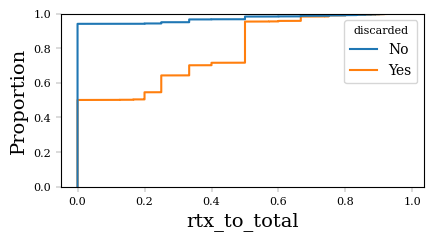

In [202]:
sns.ecdfplot(data=df, x='rtx_to_total', hue='discarded')

<AxesSubplot: xlabel='num_vid', ylabel='num_rtx'>

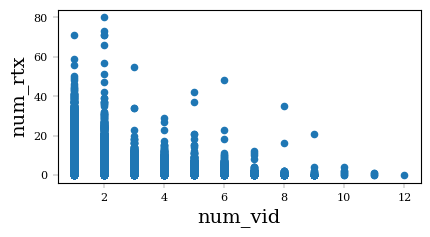

In [203]:
df.plot.scatter('num_vid', 'num_rtx')

<AxesSubplot: xlabel='num_pkts', ylabel='Proportion'>

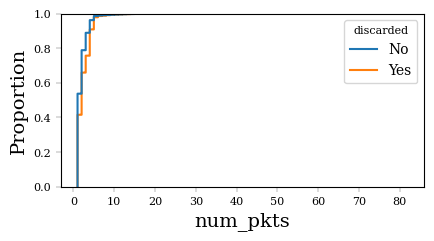

In [161]:
sns.ecdfplot(data=df, x='num_pkts', hue='discarded')

In [157]:
df.iloc[260:266]

,rtp.timestamp,frame.time_epoch,udp.length,rtp.seq,iat,num_pkts,frame_arr_time,discarded
260,3.105175e+09,"[1675903899.1766481, 1675903899.1881459]","[670.0, 671.0]","[601, 602]","[0.028167724609375, 0.011497735977172852]",2.0,11497.735977,No
261,3.105178e+09,"[1675903899.212888, 1675903899.2252767]","[792.0, 792.0]","[603, 604]","[0.02474212646484375, 0.01238870620727539]",2.0,12388.706207,No
262,3.105182e+09,"[1675903899.2638505, 1675903899.2875233, 16759...","[1043.0, 1043.0, 1043.0, 1044.0]","[605, 607, 608, 609]","[0.0385737419128418, 0.023672819137573242, 0.0...",5.0,45371.055603,Yes
263,3.105186e+09,[1675903899.3184247],[1116.0],[610],[0.009203195571899414],1.0,9203.195572,No
264,3.105189e+09,"[1675903899.3423278, 1675903899.349028]","[701.0, 702.0]","[611, 612]","[0.009951114654541016, 0.006700277328491211]",2.0,6700.277328,No
265,3.105193e+09,[1675903899.3786373],[784.0],[613],[0.029609203338623047],1.0,29609.203339,No
